## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [1]:
%matplotlib inline

#TODO

import matplotlib.pyplot as plt
from IPython import display

import itertools
import random
import time

import numpy

import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from torch.nn import Module, ReLU, MaxPool2d, Conv2d, Linear, CrossEntropyLoss


torch.manual_seed(566)
random.seed(566)

In [2]:
workspace = 'workspace'
origin = FashionMNIST(workspace, download=True, transform=ToTensor())

tmp = iter(DataLoader(origin, batch_size=len(origin))).next()[0]
features_mean, features_std = tmp.mean().item(), tmp.std().item()

data_transform = Compose([ToTensor(), Normalize((features_mean,), (features_std,))])

train = FashionMNIST(workspace, download=True, transform=data_transform)
test = FashionMNIST(workspace, train=False, download=True, transform=data_transform)

Classes representers:


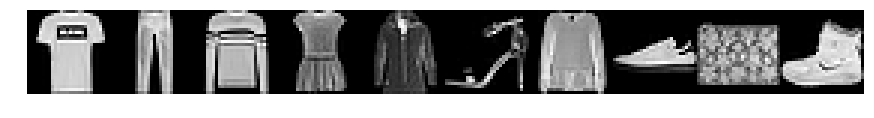

In [3]:
def draw_images(images):
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.axis('off')
    numpy_images = numpy.concatenate([image.numpy().reshape(28, 28).T for image in images]).T
    ax.imshow(numpy_images, cmap='gray', interpolation='nearest')

def show_representers():
    samples = DataLoader(dataset=origin, batch_size=1000)
    representers = {}
    images, labels = iter(samples).next()
    for image, label in zip(images, labels):
        if label.item() not in representers.keys():
            representers[label.item()] = image
    print("Classes representers:")
    draw_images([representers[i] for i in sorted(representers.keys())])
    
show_representers()

In [4]:
class MyOwnCNN(torch.nn.Module):
    def __init__(self):
        super(MyOwnCNN, self).__init__()

        self.convolution_layers = nn.Sequential(
            Conv2d(1, 3, 5, padding=2),
            ReLU(),
            MaxPool2d(2),
            Conv2d(3, 5, 5, padding=2),
            ReLU(),
            MaxPool2d(2))
        self.linear_layers = nn.Sequential(
            Linear(7 * 7 * 5, 64),
            ReLU(),
            Linear(64, 10))

    def forward(self, x):
        x = self.convolution_layers(x)
        x = x.view(-1, 7 * 7 * 5)
        x = self.linear_layers(x)
        return x

In [5]:
def train_classifier(classifier, loss_function, steps, batch, lr, train, test):
    batch_loader = DataLoader(train, batch_size=batch, shuffle=True)
    train_loader = DataLoader(train, batch_size=len(train))
    test_loader = DataLoader(test, batch_size=len(test))
    
    
    train_features, train_marks = iter(train_loader).next()
    test_features, test_marks = iter(test_loader).next()
    
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    
    train_loss = []
    test_loss = []
    train_accuracy = []
    test_accuracy = []

    for step in range(steps):
        for features, marks in batch_loader:
            optimizer.zero_grad()
            predictions = classifier(features)
            loss_value = loss_function(predictions, marks)
            loss_value.backward()
            optimizer.step()
            
        with torch.no_grad():
            train_predictions = classifier(train_features)
            test_predictions = classifier(test_features)
            train_loss.append(loss_function(train_predictions, train_marks).item())
            test_loss.append(loss_function(classifier(test_features), test_marks).item())
            train_accuracy.append(torch.mean(torch.eq(torch.argmax(train_predictions, 1), train_marks).float()).item())
            test_accuracy.append(torch.mean(torch.eq(torch.argmax(test_predictions, 1), test_marks).float()).item())
        print("Step #", step, ", train loss=", train_loss[-1], ", test_loss=", test_loss[-1], sep='')
        print("         train accuracy=", train_accuracy[-1], ", test accuracy=", test_accuracy[-1], sep='')

    return train_loss, train_accuracy, test_loss, test_accuracy
    
train_log, train_accuracy, test_log, test_accuracy = train_classifier(MyOwnCNN(), CrossEntropyLoss(), 20, 100, 0.001, train, test)

Step #0, train loss=0.45147204399108887, test_loss=0.4791747033596039
         train accuracy=0.8362500071525574, test accuracy=0.8259999752044678
Step #1, train loss=0.3821433186531067, test_loss=0.4147109389305115
         train accuracy=0.8611833453178406, test accuracy=0.847000002861023
Step #2, train loss=0.3435918092727661, test_loss=0.3775032162666321
         train accuracy=0.8734666705131531, test accuracy=0.8644000291824341
Step #3, train loss=0.3310707211494446, test_loss=0.3693346679210663
         train accuracy=0.8792499899864197, test accuracy=0.8675000071525574
Step #4, train loss=0.30919331312179565, test_loss=0.35344138741493225
         train accuracy=0.8862666487693787, test accuracy=0.8733000159263611
Step #5, train loss=0.2959403097629547, test_loss=0.34481292963027954
         train accuracy=0.8916000127792358, test accuracy=0.8748000264167786
Step #6, train loss=0.28009259700775146, test_loss=0.3266415297985077
         train accuracy=0.8980000019073486, test ac

In [6]:
def show_plot(y1, label1, y2, label2):
    plt.clf()
    plt.plot(y1, label=label1)
    plt.plot(y2, label=label2)
    plt.legend()
    plt.show()

# График функции потерь

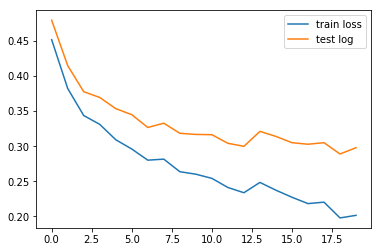

In [7]:
show_plot(train_log, 'train loss', test_log, 'test log')

# График точности

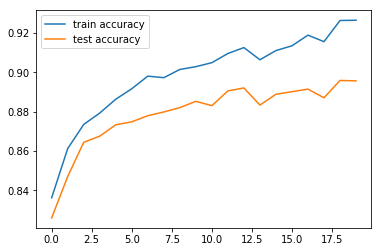

In [8]:
show_plot(train_accuracy, 'train accuracy', test_accuracy, 'test accuracy')